### This information is based on competition results owned and maintained by the
### World Cube Assocation, published at https://worldcubeassociation.org/results
### as of November 25, 2022.

In [ ]:
import pandas as pd

results = pd.read_csv("export/WCA_export_Results.tsv", delimiter="\t")
eventsdf = pd.read_csv("export/WCA_export_Competitions.tsv", delimiter="\t")

In [2]:
class Competitor:
    def __init__(self, id) -> None:
        self.id = id
        self.compCount = 0
        self.competitions = []

    def add_competition(self, name):
        #This makes sure a competition cannot be added twice
        if len(self.competitions) == 0 or self.competitions[-1] != name:
            self.compCount += 1
            self.competitions.append(name)

    def __str__(self):
        return str(self.id) + ", " + str(self.compCount)

length = len(results["competitionId"])
competitors = {}

for index in range(length):
    personId = results["personId"][index]
    competitionId = results["competitionId"][index]
    if competitors.get(personId) is not None:
        #competitor is a returning competitor
        competitors[personId].add_competition(competitionId)
    else:
        #competitor is a first timer
        competitors[personId] = Competitor(personId)
        competitors[personId].add_competition(competitionId)


In [33]:
class Competition:
    def __init__(self, id) -> None:
        self.id = id
        self.newbies = []
        self.competitors = []
        self.newbiecount = 0
        self.returningNewbies = 0
        self.competitorCount = 0
        self.isSingleDayCompetition = None

    def add_newbie(self, id, returning):
        self.newbies.append(id)
        self.newbiecount += 1
        if returning:
            self.returningNewbies += 1

    def add_competitor(self, id):
        self.competitors.append(id)
        self.competitorCount += 1
    
    def score(self):
        # return self.returningNewbies - (self.newbiecount - self.returningNewbies)
        # return (self.returningNewbies / self.newbiecount) * (self.returningNewbies - (self.newbiecount - self.returningNewbies))
        # if self.newbiecount < 30: return 0
        return (self.returningNewbies / self.newbiecount)

    def __lt__(self, other):
         return self.score() < other.score()

    def __gt__(self, other):
         return self.score() > other.score()

    def __str__(self):
        return "Competition( {} ) ".format(self.id)

events = {}

keys = competitors.keys()
for key in keys:
    cmp = competitors[key]
    firstevent = cmp.competitions[0]
    returned = True if cmp.compCount > 1 else False

    #populate spot in dict if not already done so
    if events.get(firstevent) is None:
        events[firstevent] = Competition(firstevent)
    
    events[firstevent].add_newbie(key, returned)

#add all non-returning competitors to competitions
#this is done seperately so comps without newbies are not entered
for key in keys:
    cmp = competitors[key]
    for e in cmp.competitions:
        if events.get(e) is not None:
            events[e].add_competitor(key)


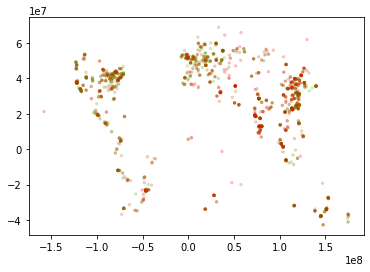

In [4]:
#retention by region

import matplotlib.pyplot as plt
from math import pow

cmps = list(events.values())
cmps.sort(reverse=True)

x = []
y = []
colors = []

for c in cmps:
    if c.newbiecount < 30: continue
    # print(c, c.score(), c.newbiecount)
    info = eventsdf.loc[eventsdf['id'] == c.id]
    y.append(info['latitude'])
    x.append(info['longitude'])
    colors.append((1-c.score(), c.score(), 0))

plt.scatter(x, y, alpha=0.2, s=6, c=colors)
plt.savefig('region.png', dpi=600)

In [25]:
#multi day vs one day competitions

import matplotlib.pyplot as plt
import numpy as np

data = np.zeros((2,))
divisors = np.zeros((2,))

for event in list(events.values()):
    # if event.newbiecount < 20: continue
    info = eventsdf.loc[eventsdf['id'] == event.id]
    if int(info['day']) != int(info['endDay']):
        data[1] += (event.score())
        divisors[1] += 1
        events[event.id].isSingleDayCompetition = False
    else:
        data[0] += (event.score())
        divisors[0] += 1
        events[event.id].isSingleDayCompetition = True

competitionLengthScores = data/divisors

print("Average score for single-day competitions:")
print(competitionLengthScores[0])
print("Average score for multi-day competitions:")
print(competitionLengthScores[1])

print(divisors)

#Conclusion: Makes little to no difference

Average score for single-day competitions:
0.47285898930282133
Average score for multi-day competitions:
0.46768092521501353
[4377. 3452.]


In [ ]:
#Events compared

import matplotlib.pyplot as plt
import numpy as np

eventIndices = {
    "222" : 0,
    "333":1,
    "333bf":2,
    "333fm":3,
    "333ft":4,
    "333mbf":5,
    "333mbo":6,
    "333oh":7,
    "444":8,
    "444bf":9,
    "555":10,
    "555bf":11,
    "666":12,
    "777":13,
    "clock":14,
    "magic":15,
    "minx":16,
    "mmagic":17,
    "pyram":18,
    "skewb":19,
    "sq1":20,
}

data = np.zeros((21,))
divisors = np.zeros((21,))

for event in list(events.values()):
    evts = list(eventsdf.loc[eventsdf['id'] == event.id]['eventSpecs'])[0].split(' ')
    for e in evts:
        data[eventIndices[e]] += event.score()
        divisors[eventIndices[e]] += 1

eventscores = data/divisors

for i in range(21):
    print(list(eventIndices.keys())[i], end=',')
    print(eventscores[i])


/tmp/ipykernel_10006/1257950443.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(data/divisors)
/tmp/ipykernel_10006/1257950443.py:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((divisors / (max(divisors)*4)) + .4)


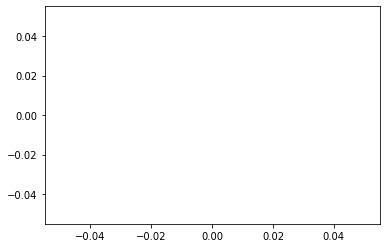

In [49]:
#Number of events

import matplotlib.pyplot as plt
import numpy as np

data = np.zeros((21,))
divisors = np.zeros((21,))

for event in list(events.values()):
    #This excludes 2-day competitions
    if not event.isSingleDayCompetition:
        continue
    numberOfEvents = len(list(eventsdf.loc[eventsdf['id'] == event.id]['eventSpecs'])[0].split(' '))
    data[numberOfEvents] += event.score()
    divisors[numberOfEvents] += 1

    if numberOfEvents > 10:print(event.id)

plt.plot(data/divisors)
plt.plot((divisors / (max(divisors)*4)) + .4)
plt.show() 

#Shows a very clear upward trend
#The more events there are the better it is. This excludes multi-day competitions because it messes with the numbers

[-0.00025904]
0.4887188740361786


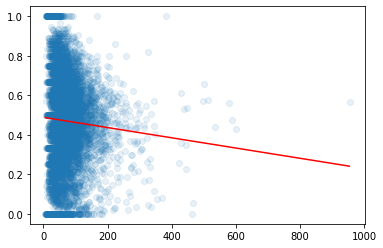

In [48]:
#Number of competitors
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x_train = []
y_train = []

for event in list(events.values()):
    x_train.append([event.competitorCount])
    y_train.append(event.score())

model = LinearRegression().fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)  # <- note now we're calling the function 'formula' with x
    plt.plot(x, y, c=(1, 0, 0))

def my_formula(x):
    return (model.coef_[0]*x) + model.intercept_

graph(my_formula, range(min(x_train)[0], max(x_train)[0]))
plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

#Conclusion : The more competitors, the worse the retention rate is